In [1]:
using SparseArrays
using LinearAlgebra
using Plots
using Statistics
using SuiteSparse
E0 = 1;
Emin = 1e-9;
nu = 0.3;
using ForwardDiff

## There is the function top88 using AD

*This code uses the Matlab code "top88" from Ole Sigmund, to which I add the uautomatic differentiation tool*

What is needed to know :
 -  This code has been written by Robin Grapin for he's work at Supaéro, under the supervision of Joseph Morlier
 -  The modules above must be imported before running the code
 -  The goal here is to compare the efficiency of the code and to compare it to the version without AD.


The given objective function must take two arguments of dimension nelx x nely : 
 - The matrix of the mass repartition x
 - ce = u K u

The modifications in camparation to the topo88 code I wrote are between the lines 64 and 74, where the process is not making a difference in function of the objective function. In these lines, we use the module "ForwardDiff" to calculate the derivative of the objective function.

In [2]:
function top88AD(nelx,nely,objectif ,volfrac = 0.4 ,penal = 3,rmin = 2.5 ,ft = 1)
        
    A11 = [12  3 -6 -3;  3 12  3  0; -6  3 12 -3; -3  0 -3 12]
    A12 = [-6 -3  0  3; -3 -6 -3 -6;  0 -3 -6  3;  3 -6  3 -6]
    B11 = [-4  3 -2  9;  3 -4 -9  4; -2 -9 -4 -3;  9  4 -3 -4]
    B12 = [ 2 -3  4 -9; -3  2  9 -2;  4  9  2  3; -9 -2  3  2]
    KE = 1/(1-nu^2)/24*([A11 A12;A12' A11]+nu*[B11 B12;B12' B11])

    nodenrs = reshape(1:(1+nelx)*(1+nely),1+nely,1+nelx); #number of the nodes in columns
    edofVec = reshape(2*nodenrs[1:end-1,1:end-1].+1,nelx*nely,1) ;#1st dof of each element (x top left)
    edofMat = zeros(nelx*nely, 8); #every line i contains the 8 dof of the ith element
    noeudsvoisins = [0 1 2*nely.+[2 3 0 1] -2 -1];
    for i = 1:8
        for j = 1:nelx*nely
            edofMat[j,i]= edofVec[j]+ noeudsvoisins[i] ;
        end
    end
    #maillage
    iK = reshape(kron(edofMat,ones(8,1))',64*nelx*nely,1);# line to build  K
    jK = reshape(kron(edofMat,ones(1,8))',64*nelx*nely,1);# columns
    #F = spzeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1;   impossible to solve with F sparse in Julia
    F = zeros(2*(nely+1)*(nelx+1),1); F[2,1] = -1; 
    U = zeros(2*(nely+1)*(nelx+1),1);
    fixeddofs = union(1:2:2*(nely+1),[2*(nelx+1)*(nely+1)]);
    alldofs = 1:2*(nely+1)*(nelx+1);
    freedofs = setdiff(alldofs,fixeddofs);
    #filtering is linear + chain's rule -> matricial opration with operator H
    iH = ones(nelx*nely*(2*(convert(Int64,ceil(rmin)-1))+1)^2);#lines H
    jH = ones(size(iH));# columns
    sH = zeros(size(iH));# values
    k = 0;
    for i1 = 1:nelx
        for j1 = 1:nely
            e1 = (i1-1)*nely+j1;
            for i2 = max(i1-(ceil(rmin)-1),1):min(i1+(ceil(rmin)-1),nelx)
                for j2 = max(j1-(ceil(rmin)-1),1):min(j1+(ceil(rmin)-1),nely)
                    e2 = (i2-1)*nely+j2;
                    k = k+1;
                    iH[k] = e1;
                    jH[k] = e2;
                    sH[k] = max(0,rmin-sqrt((i1-i2)^2+(j1-j2)^2));
                end
            end
        end
    end
    H = sparse(iH,jH,sH);# matrix of the Hei
    Hs = [sum(H[i,:]) for i = 1:(size(H)[1])];# sum of the Hei for e fixed -> coeffs used to divide in the filter
    #variables
    x = volfrac*ones(nely,nelx);
    xPhys = x;#new variable for the density filter
    loop = 0;
    change = 1;
    cValues = []
    while change > 0.01
        loop = loop + 1;
        
        sK = [j*((i+Emin)^penal) for i in ((E0-Emin)*xPhys[:]') for j in KE[:] ];#new values EF
        K = sparse(iK[:],jK[:],sK); K = (K+K')/2;# force to be symmetric
        KK = cholesky(K[freedofs,freedofs]);
        U[freedofs] = KK\F[freedofs];
        
        # analyse, objective function 
        edM = [convert(Int64,i) for i in edofMat] ;#to index by int
        mat = (U[edM]*KE).*U[edM];
        ce = reshape([sum(mat[i,:]) for i = 1:(size(mat)[1])],nely,nelx);

        #new
        c = objectif(xPhys,ce) #sum(sum((Emin*ones(size(xPhys)).+(xPhys.^penal)*(E0-Emin)).*ce));
        push!(cValues,c)
        
        #here we use AD :      
          #to make of it an unary function
        dc = -ForwardDiff.gradient(x -> objectif(x,ce), xPhys)#-penal*(E0-Emin)*xPhys.^(penal-1).*ce;
        dv = ones(nely,nelx);
        
        #filtering : maybe other filters are needed if the objective function is not the sensitivity
        if ft == 1
            dc[:] = H*(x[:].*dc[:])./Hs./max(1e-3,maximum(x[:]));
        elseif ft == 2
            dc[:] = H*(dc[:]./Hs);
            dv[:] = H*(dv[:]./Hs);
        end
        #Lagrangian multiplicators research, upload of the density x
        l1 = 0; l2 = 1e9; move = 0.2;
        xnew = zeros(nely, nelx);
        while (l2-l1)/(l1+l2) > 1e-3
            lmid = 0.5*(l2+l1);
            RacBe = sqrt.(-dc./dv/lmid) ;
            XB = x.*RacBe ;
            for i = 1:nelx
                for j = 1:nely
                    xji = x[j,i];
                    xnew[j,i]= max(0.001,max(xji-move,min(1,min(xji+move,XB[j,i]))));
                end
            end  
            if ft == 1
                xPhys = xnew;
            elseif ft == 2 # if we chose the density filter
                xPhys[:] = (H*xnew[:])./Hs;
            end
            if sum(xPhys[:]) > volfrac*nelx*nely
                l1 = lmid;
            else 
                l2 = lmid; 
            end
        end
        change = maximum(abs.(x-xnew));
        x = xnew;
        println("loop = ", loop, "Change = ", change ," c = ", c , " densité struct = ", mean(x) )
        if loop == 25
            return heatmap(x), loop, cValues
        end
    end
    return heatmap(x ), loop , cValues
end

top88AD (generic function with 5 methods)

loop = 1Change = 0.2 c = 240.55295821333357 densité struct = 0.4998520540677216
loop = 2Change = 0.20000000000000007 c = 142.29012812657385 densité struct = 0.4999542563374929
loop = 3Change = 0.20000000000000007 c = 101.29042745368754 densité struct = 0.5002055990575159
loop = 4Change = 0.20000000000000007 c = 80.66559467700088 densité struct = 0.5000701665639053
loop = 5Change = 0.20000000000000007 c = 70.50380077730274 densité struct = 0.4999593512378573
loop = 6Change = 0.20000000000000007 c = 62.76373407505786 densité struct = 0.5001263852460752
loop = 7Change = 0.20000000000000007 c = 57.5694569236679 densité struct = 0.5001217271799541
loop = 8Change = 0.20000000000000007 c = 53.325317688747006 densité struct = 0.4999988517633573
loop = 9Change = 0.20000000000000007 c = 50.258491516120166 densité struct = 0.5000234485734584
loop = 10Change = 0.20000000000000007 c = 48.81073539248547 densité struct = 0.499969988891163
loop = 11Change = 0.20000000000000007 c = 48.11940887677639 de

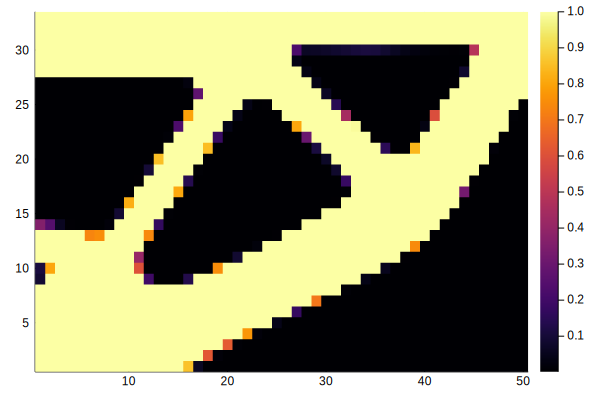

In [3]:
penal = 3
sensi( x, ce)= sum(sum((Emin*ones(size(x)).+(x.^penal)*(E0-Emin)).*ce));# example of the sensitivity to see if the results do match


x,l,values= top88AD(50,33,sensi ,0.5,3,2)

x

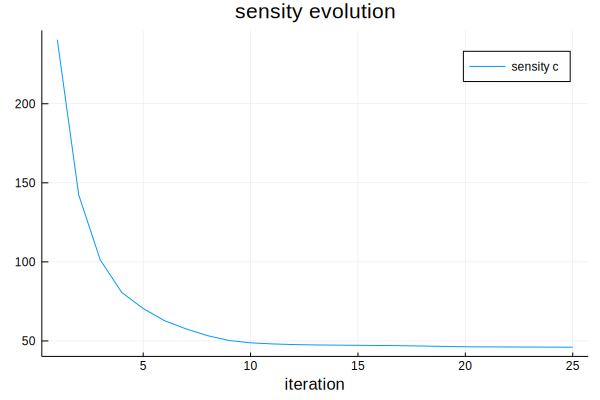

In [4]:
plot(1:l,values,title = "sensity evolution", label = "sensity c") #evolution of c during the process
xlabel!("iteration")

In [5]:
@time top88AD(100,100,sensi,0.5,3,2);

loop = 1Change = 0.2 c = 181.02944558470028 densité struct = 0.49995144886389187
loop = 2Change = 0.20000000000000007 c = 87.70747378137004 densité struct = 0.5001614594571799
loop = 3Change = 0.20000000000000007 c = 51.26685653381925 densité struct = 0.49987273213909994
loop = 4Change = 0.20000000000000007 c = 37.107211620138884 densité struct = 0.5000877840246694
loop = 5Change = 0.20000000000000007 c = 33.4722698714435 densité struct = 0.500032469187293
loop = 6Change = 0.20000000000000007 c = 31.7012718049617 densité struct = 0.500038081949538
loop = 7Change = 0.20000000000000007 c = 30.680779048340334 densité struct = 0.4999725989287503
loop = 8Change = 0.20000000000000007 c = 30.056612408082696 densité struct = 0.4999948254122206
loop = 9Change = 0.20000000000000007 c = 29.697007899596613 densité struct = 0.49999010865046273
loop = 10Change = 0.20000000000000007 c = 29.509405391612148 densité struct = 0.4999967663976441
loop = 11Change = 0.20000000000000007 c = 29.383561398743222

## Comparation of the algorithms

About the speed, the "classic" algorithm top88 took, for the "relatively big" example 100x100 :

12.845634 seconds (156.44 M allocations: 6.358 GiB, 10.76% gc time)

against 58.238602 seconds (182.39 M allocations: 70.522 GiB, 13.31% gc time) for top88AD (stopping both of them after 25 iteration if the stopping condition on the change isn't reached.).

top88 has already the explicit formulae of the derivative of the sensity, that is why it is quicker. But we can appreciate the precicion of top88_AD, which gave the same results with 11 exact decimals. This algorithm may also be used with other functions than the sensity.